In [5]:
# Modeling and Analysis
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../src'))

from keyword_extraction import extract_keywords_tfidf
from topic_modeling import lda_topic_modeling
from event_clustering import cluster_events
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
data_df = pd.read_csv("../data/data.csv")
domain_location_df = pd.read_csv("../data/domains_location.csv")

# Merge datasets for a complete view
merged_df = data_df.merge(domain_location_df, left_on='source_name', right_on='SourceCommonName', how='left')

# Keyword extraction using TF-IDF
print("Keyword Extraction using TF-IDF:")
keywords = extract_keywords_tfidf(merged_df, 'full_content')
print("Extracted Keywords:", keywords)

# Topic modeling using LDA
print("Topic Modeling using LDA:")
num_topics = 5  # Adjust the number of topics as needed
lda_model, count_vectorizer = lda_topic_modeling(merged_df, num_topics=num_topics)


Keyword Extraction using TF-IDF:
Extracted Keywords: ['000' 'company' 'market' 'price' 'quarter' 'report' 'said' 'shares'
 'stock' 'year']
Topic Modeling using LDA:


In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, count_vectorizer.get_feature_names_out(), no_top_words)


Topic 1:
said people 2023 israel gaza year november time years children
Topic 2:
market 2023 global company growth research new data business industry
Topic 3:
state said government nigeria court election people university president governor
Topic 4:
india news read said new like year time times view
Topic 5:
shares company stock quarter price rating report 00 000 stocks


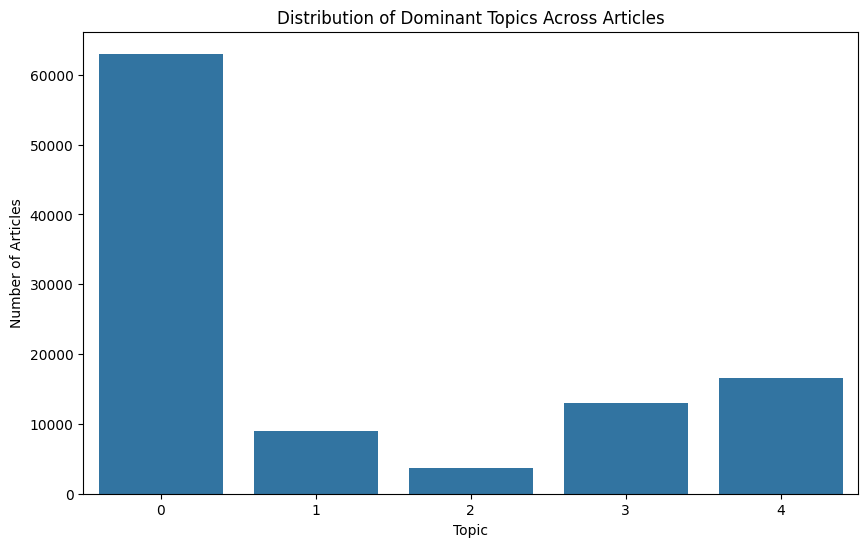

In [7]:
topic_values = lda_model.transform(count_vectorizer.transform(merged_df['full_content'].fillna("")))
merged_df['Dominant_Topic'] = topic_values.argmax(axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x='Dominant_Topic', data=merged_df)
plt.title("Distribution of Dominant Topics Across Articles")
plt.xlabel("Topic")
plt.ylabel("Number of Articles")
plt.show()

Event Clustering using K-Means:


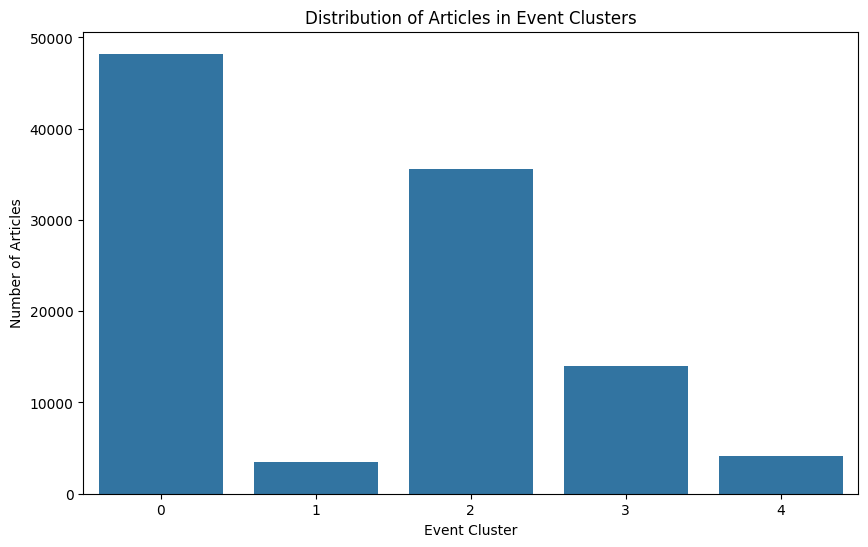

In [8]:
# Event clustering using K-Means
print("Event Clustering using K-Means:")
num_clusters = 5  # Adjust the number of clusters as needed
clustered_data = cluster_events(merged_df, num_clusters=num_clusters)

# Visualize the number of articles in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='event_cluster', data=clustered_data)
plt.title("Distribution of Articles in Event Clusters")
plt.xlabel("Event Cluster")
plt.ylabel("Number of Articles")
plt.show()

In [9]:
# Further analysis based on clustering
print("Top Articles in Each Cluster:")
for i in range(num_clusters):
    print(f"\nCluster {i} Articles:")
    cluster_articles = clustered_data[clustered_data['event_cluster'] == i]['title'].head(5)
    for article in cluster_articles:
        print(f" - {article}")

Top Articles in Each Cluster:

Cluster 0 Articles:
 - RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。
 - UN Chief Urges World to 'Stop the Madness' of Climate Change
 - 200 foreigners, dual nationals cut down in Hamas assault. Here’s where they were from
 - 中印交惡令尼泊爾機場難以發展國際航線
 - More than 130 people have reportedly been taken to Gaza as hostages. Here's what we know

Cluster 1 Articles:
 - Pro-Israel rallies allowed in India but Palestine solidarity sees crackdown
 - Gaza growing more desperate ‘by the hour’, UN chief warns
 - Washington says 9 US citizens killed in Hamas operation against Israel
 - 'I don't really have any other choice': Young Israelis around the world return home after Hamas attacks
 - Nepal: First batch of 254 students, stranded amid Israel-Hamas war, land in Kathmandu

Cluster 2 Articles:
 - UN Chief Urges World To 'Stop The Madness' Of Climate Change
 - Sikkim warning: Hydroelectricity push must be accompanied by safety measures
 - No nation in the world is buying more plan

In [10]:
# Further analysis based on clustering
print("Top Articles in Each Cluster:")
for i in range(num_clusters):
    print(f"\nCluster {i} Articles:")
    cluster_articles = clustered_data[clustered_data['event_cluster'] == i]['title'].head(5)
    for article in cluster_articles:
        print(f" - {article}")

KeyError: 'topic'

<Figure size 1200x800 with 0 Axes>

In [4]:
from sklearn.cluster import KMeans

# Apply K-Means to cluster articles into events
kmeans_model = KMeans(n_clusters=20, random_state=42)
kmeans_labels = kmeans_model.fit_predict(tfidf_matrix_content)

# Assign cluster labels to the articles
news_df['event_cluster'] = kmeans_labels

# Analyze the number of articles per event
event_counts = news_df['event_cluster'].value_counts()
print("Number of articles per event cluster:")
print(event_counts.head(10))


Number of articles per event cluster:
event_cluster
0     47656
4     10462
9      6553
14     5019
6      4570
18     3958
13     3069
17     3043
16     2772
3      2304
Name: count, dtype: int64


In [ ]:
# Find the earliest report date for each event cluster
earliest_report = news_df.groupby('event_cluster')['published_at'].min()

# Find the site that reported each event first
first_reporter = news_df.loc[news_df.groupby('event_cluster')['published_at'].idxmin()]

print("Sites that reported events the earliest:")
print(first_reporter[['event_cluster', 'source_name', 'published_at']].head(10))


In [ ]:
# Analyze which events have the highest reporting frequency
most_reported_events = event_counts.sort_values(ascending=False).head(10)
print("Most reported events:")
print(most_reported_events)


Most reported events:
event_cluster
0     47656
4     10462
9      6553
14     5019
6      4570
18     3958
13     3069
17     3043
16     2772
3      2304
Name: count, dtype: int64


In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table of event clusters and sources
event_source_matrix = pd.crosstab(news_df['event_cluster'], news_df['source_name'])

# Compute correlation between sites based on event reporting
site_correlation = event_source_matrix.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(site_correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Between News Sites Based on Event Reporting")
plt.show()
